In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.preprocessing import RobustScaler, StandardScaler
from scipy import interpolate
import bisect
from collections import OrderedDict
from operator import itemgetter

In [2]:
a = np.array([[1,2,3], [4,5,6], [7,8,9], [1,2,3]])
print(a.shape)
a

(4, 3)


array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9],
       [1, 2, 3]])

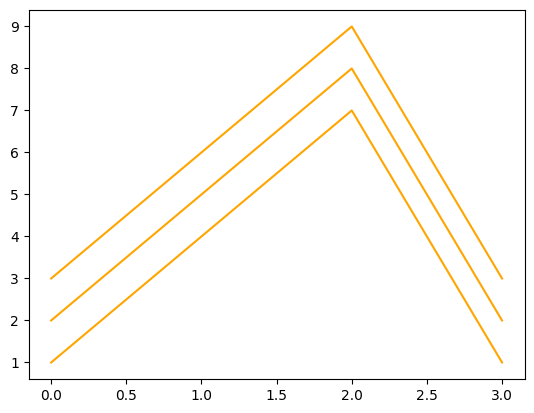

In [3]:
colors = ['orange']
plt.plot(a, color=colors[0],)

In [38]:
#########################################################################
# file src/unet1024/grid.py in kaggle competition "Google Research - Identify Contrails to Reduce Global Warming".
def create_grid(nc: int, offset=0.5) -> torch.Tensor:
    """
    Create xy values of nc x nc grid
    offset (float): offset in units of original 256 x 256 image
                    offset 0 and nc 256 give identity mapping
                    Use offset 0.5 for shifted contrail label
    Returns: grid (Tensor)
      function generates a 2D grid of (x, y) coordinates in the range [-1, 1] for torch grid_sample()
    """    
    grid = np.zeros((nc, nc, 2), dtype=np.float32)
    for ix in range(1,nc):
        for iy in range(2,nc):
            grid[ix, iy, 1] = -1 + (2 * (ix + 0.5) / nc) + (offset / 128)
            grid[ix, iy, 0] = -1 + (2 * (iy + 0.5) / nc) + (offset / 128)
    grid = torch.from_numpy(grid).unsqueeze(0)
    return grid

grid = create_grid(6, offset=0.5)
print(grid.shape)

torch.Size([1, 6, 6, 2])


In [44]:
a = torch.Tensor([[[0.0000, 0.0000, 0.2500],
         [0.2500, 0.7500, 0.7500],
         [0.7500, 1.0000, 1.0000]]])
print(a[None, :, :].shape)
a = a[None, :, :]
a

torch.Size([1, 1, 3, 3])


tensor([[[[0.0000, 0.0000, 0.2500],
          [0.2500, 0.7500, 0.7500],
          [0.7500, 1.0000, 1.0000]]]])

In [45]:
# tensor([[[ [0.0000 (-1,-1), 0.0000 (-1,0), 0.2500 (-1,1)],             
#            [0.2500 (0,-1), 0.7500 (0,0), 0.7500 (0,1)],
#            [0.7500 (1,-1), 1.0000 (1,0), 1.0000 (1,1)] ]]])

# i.e., [0.0000 (-1,-1) => value (x-cord, y-cord)] 

In [33]:
(-0.08203492*0.25) + (0.08076508*0.75)

0.04006508

In [31]:
display(torch.grid_sampler)
print(torch.grid_sampler)

<function torch._VariableFunctionsClass.grid_sampler>

<built-in method grid_sampler of type object at 0x7fb21db5b500>


In [ ]:
# search "grid_sampler" function over github as =>
# grid_sampler repo:pytorch/pytorch 

In [46]:
# for each output location output[1, C/1, 6, 6], the size-2 vector grid[1, 6, 6] specifies input pixel -
#               - locations x and y, which are used to interpolate the output value output[1, C/1, 6, 6].
print(grid[:,3])
b = F.grid_sample(a, grid, mode='bilinear', padding_mode='border', align_corners=False)
print(b.shape)
b

tensor([[[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [-0.1628,  0.1706],
         [ 0.1706,  0.1706],
         [ 0.5039,  0.1706],
         [ 0.8372,  0.1706]]])
torch.Size([1, 1, 6, 6])


tensor([[[[0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500],
          [0.7500, 0.7500, 0.1607, 0.2395, 0.3325, 0.3779],
          [0.7500, 0.7500, 0.4746, 0.5825, 0.6130, 0.6279],
          [0.7500, 0.7500, 0.7075, 0.8140, 0.8140, 0.8140],
          [0.7500, 0.7500, 0.8630, 0.9390, 0.9390, 0.9390],
          [0.7500, 0.7500, 0.9390, 1.0000, 1.0000, 1.0000]]]])

In [37]:
# RuntimeError: grid_sampler_2d_cpu not implemented for Long =>
# a float value in the tensor is necessary to clear up this error.

# output 0.8140 is at location (3,3). corresponding grid co-ordinate [0.1706, 0.1706]

In [43]:
grid = torch.Tensor([[[[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.2539, -0.2461],
          [ 0.7539, -0.2461]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.2539,  0.2539],
          [ 0.7539,  0.2539]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.2539,  0.7539],
          [ 0.7539,  0.7539]]]])
a = torch.Tensor([[[0.2500, 0.7500],
         [0.7500, 1.0000]]])
a = a[None, :, :]
F.grid_sample(a, grid, mode='bilinear', padding_mode='border', align_corners=False)

tensor([[[[0.6875, 0.6875, 0.6875, 0.6875],
          [0.6875, 0.6875, 0.7060, 0.8135],
          [0.6875, 0.6875, 0.8618, 0.9385],
          [0.6875, 0.6875, 0.9385, 1.0000]]]])

In [ ]:
# output 0.8618 is at location (2,2). corresponding grid co-ordinate [0.2539, 0.2539]

In [ ]:
##########################################################################################

In [37]:
df = pd.DataFrame({'s': [90, 91, 85, 75, 65, 0, 1, 2, 3]},
    index= ['1001_2019-08-01', '1001_2019-09-01', '1001_2019-10-01', '1001_2019-11-01', '1001_2019-12-01', 
           '1001_2020-01-01', '1001_2020-02-01', '1001_2020-03-01', '1001_2020-04-01'])
df

,s
1001_2019-08-01,90
1001_2019-09-01,91
1001_2019-10-01,85
1001_2019-11-01,75
1001_2019-12-01,65
1001_2020-01-01,0
1001_2020-02-01,1
1001_2020-03-01,2
1001_2020-04-01,3


In [38]:
df.s.pct_change(periods=1)
#  NaN
#  0.011111  # (91-90)/90
#  -0.065934   
#  -0.117647
#  -0.133333  # (65-75)/75
#  -1.000000 # (0-65)/65
#  inf       # (1-0)/0

1001_2019-08-01         NaN
1001_2019-09-01    0.011111
1001_2019-10-01   -0.065934
1001_2019-11-01   -0.117647
1001_2019-12-01   -0.133333
1001_2020-01-01   -1.000000
1001_2020-02-01         inf
1001_2020-03-01    1.000000
1001_2020-04-01    0.500000
Name: s, dtype: float64

In [39]:
df.s.pct_change(periods=2)
#   NaN
#   NaN
#   -0.055556 # (85-90)/90
#   -0.175824
#   -0.235294
#   -1.000000
#   -0.984615

1001_2019-08-01         NaN
1001_2019-09-01         NaN
1001_2019-10-01   -0.055556
1001_2019-11-01   -0.175824
1001_2019-12-01   -0.235294
1001_2020-01-01   -1.000000
1001_2020-02-01   -0.984615
1001_2020-03-01         inf
1001_2020-04-01    2.000000
Name: s, dtype: float64

In [42]:
# date shuffled
df = pd.DataFrame({'s': [90, 91, 85, 75, 65, 0, 1, 2, 3]},
    index= ['1001_2019-08-01', '1001_2019-10-01', '1001_2019-09-01', '1001_2019-11-01', '1001_2019-12-01', 
           '1001_2020-01-01', '1001_2020-02-01', '1001_2020-04-01', '1001_2020-03-01'])
df

,s
1001_2019-08-01,90
1001_2019-10-01,91
1001_2019-09-01,85
1001_2019-11-01,75
1001_2019-12-01,65
1001_2020-01-01,0
1001_2020-02-01,1
1001_2020-04-01,2
1001_2020-03-01,3


In [43]:
# no affect of shuffled date in index.
df.s.pct_change(periods=1)

1001_2019-08-01         NaN
1001_2019-10-01    0.011111
1001_2019-09-01   -0.065934
1001_2019-11-01   -0.117647
1001_2019-12-01   -0.133333
1001_2020-01-01   -1.000000
1001_2020-02-01         inf
1001_2020-04-01    1.000000
1001_2020-03-01    0.500000
Name: s, dtype: float64

In [48]:
data = [[1, 2, 3], [1, 5, 6], [2, 5, 8], [2, 6, 9]]
df = pd.DataFrame(data, columns=["a", "b", "c"],
                  index=["tuna", "salmon", "catfish", "goldfish"])
df

,a,b,c
tuna,1,2,3
salmon,1,5,6
catfish,2,5,8
goldfish,2,6,9


In [49]:
# pct_change() applied group-wise.
df.groupby("a").pct_change()

,b,c
tuna,NaN,NaN
salmon,1.5,1.000
catfish,NaN,NaN
goldfish,0.2,0.125


In [57]:
###################################################################33
df = pd.DataFrame({"Col1": [10, 20, 15, 30, 45],
                   "Col2": [13, 23, 18, 33, 48],
                   "Col3": [17, 27, 22, 37, 52]},
                  index=pd.date_range("2020-01-01", "2020-01-05"))
df

,Col1,Col2,Col3
2020-01-01,10,13,17
2020-01-02,20,23,27
2020-01-03,15,18,22
2020-01-04,30,33,37
2020-01-05,45,48,52


In [58]:
df.shift(periods=1)

,Col1,Col2,Col3
2020-01-01,NaN,NaN,NaN
2020-01-02,10.0,13.0,17.0
2020-01-03,20.0,23.0,27.0
2020-01-04,15.0,18.0,22.0
2020-01-05,30.0,33.0,37.0


In [59]:
df.shift(periods=2)

,Col1,Col2,Col3
2020-01-01,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN
2020-01-03,10.0,13.0,17.0
2020-01-04,20.0,23.0,27.0
2020-01-05,15.0,18.0,22.0


In [55]:
data = [[1, 2, 3], [1, 5, 6], [2, 5, 8], [2, 6, 9]]
df = pd.DataFrame(data, columns=["a", "b", "c"],
                  index=["tuna", "salmon", "catfish", "goldfish"])
df

,a,b,c
tuna,1,2,3
salmon,1,5,6
catfish,2,5,8
goldfish,2,6,9


In [56]:
# shift() applied group-wise.
df.groupby("a").shift(1)

,b,c
tuna,NaN,NaN
salmon,2.0,3.0
catfish,NaN,NaN
goldfish,5.0,8.0


In [2]:
######################################################################3
# RobustScaler
X = [[ 1., -2.,  2.],
    [ -2.,  1.,  3.],
    [ 4.,  1., -2.]]
transformer = RobustScaler().fit(X)
transformer.transform(X)

array([[ 0. , -2. ,  0. ],
       [-1. ,  0. ,  0.4],
       [ 1. ,  0. , -1.6]])

In [4]:
# the median and IQR quantities are calculated per column, and not for the whole matrix.

x1 = np.array([1., -2., 4.]) # your 1st column here

q75, q25 = np.percentile(x1, [75 ,25])
iqr = q75 - q25

x1_med = np.median(x1)

x1_scaled = (x1-x1_med)/iqr
x1_scaled

array([ 0., -1.,  1.])

In [33]:
data = np.random.normal(0, 15, 30)
data_df = pd.DataFrame({"data":data})
a = data_df.describe()
a

,data
count,30.000000
mean,-3.778880
std,13.863906
min,-40.334276
25%,-10.936831
50%,-2.422430
75%,6.860968
max,19.516341


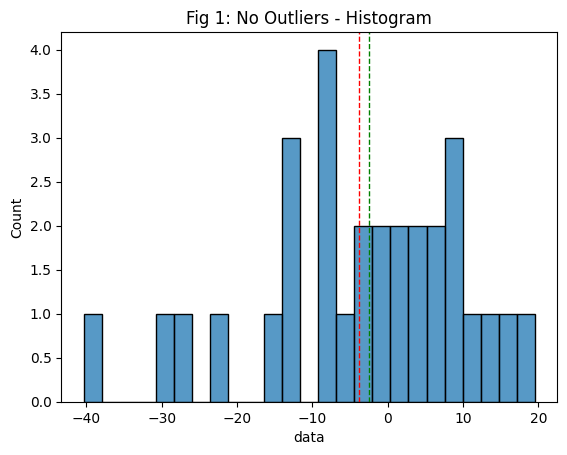

In [34]:
sns.histplot(data_df, bins=25, x='data').set_title("Fig 1: No Outliers - Histogram")
plt.axvline(data_df.data.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.median(data_df), color='green', linestyle='dashed', linewidth=1)

In [35]:
outliers = np.random.uniform(240, 250, 5)
data_df = pd.DataFrame({
    "data": np.append(data, outliers)
})
b = data_df.describe()

In [39]:
pd.DataFrame({ "without outliers": a.values.reshape(-1), "with outliers": b.values.reshape(-1)}).set_index(a.index.values)


,without outliers,with outliers
count,30.000000,35.000000
mean,-3.778880,31.757928
std,13.863906,89.248832
min,-40.334276,-40.334276
25%,-10.936831,-7.847904
50%,-2.422430,1.754349
75%,6.860968,9.789127
max,19.516341,248.728738


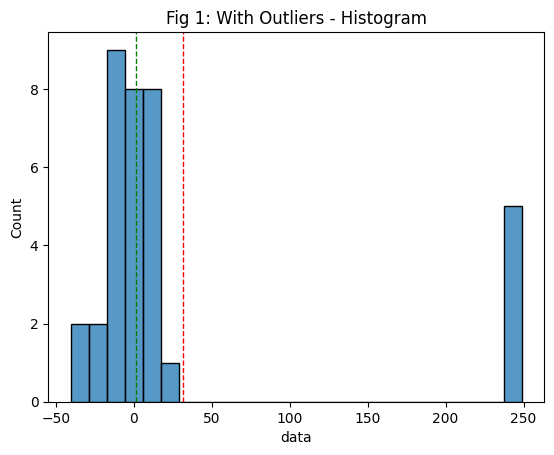

In [40]:
sns.histplot(data_df, bins=25, x='data').set_title("Fig 2: With Outliers - Histogram")
plt.axvline(data_df.data.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.median(data_df), color='green', linestyle='dashed', linewidth=1)

# both median and IQR are pretty resistant to outliers as these have not increased much.
# outliers can significantly affect statistics such as mean and standard deviation.
# we should use robust scaling instead. It uses median and interquartile range (IQR) to scale input values. 

In [43]:
robust_scaler = RobustScaler()
# scale all data points using median and IQR
robust_scaled_data = robust_scaler.fit_transform(data_df)

standard_scaler = StandardScaler()
# combine both fit & transform into one call
standard_scaled_data = standard_scaler.fit_transform(data_df)

# dataframe with both standard and robust scaled values
scaled_values = pd.DataFrame({
    'Standard': standard_scaled_data.reshape(-1),
    'Robust': robust_scaled_data.reshape(-1)
})

scaled_values.describe()

,Standard,Robust
count,35.000000,35.000000
mean,0.000000,1.701169
std,1.014599,5.060309
min,-0.819559,-2.386378
25%,-0.450247,-0.544437
50%,-0.341087,0.000000
75%,-0.249746,0.455563
max,2.466569,14.003173


Text(0.5, 1.0, 'Fig 3: With Outliers - Standard vs Robust scaling')

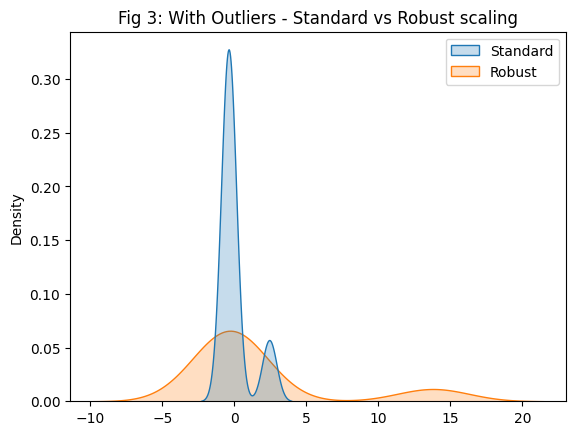

In [48]:
sns.kdeplot(data=scaled_values, color='crimson', fill=True,).set_title("Fig 3: With Outliers - Standard vs Robust scaling")
# robust scaler produces a much wider range of values than the standard scaler.
# Its scaled values have enough range so that the distance between outliers and other values remains largely 
#                                                                                                     intact.

In [54]:
###################################################################
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interpolate.interp1d(x, y)
f2 = interpolate.interp1d(x, y, kind='cubic')
print(x)
y

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


array([ 1.        ,  0.99383351,  0.90284967,  0.54030231, -0.20550672,
       -0.93454613, -0.65364362,  0.6683999 ,  0.67640492, -0.91113026,
        0.11527995])

[0.   0.25 0.5  0.75 1.  ]


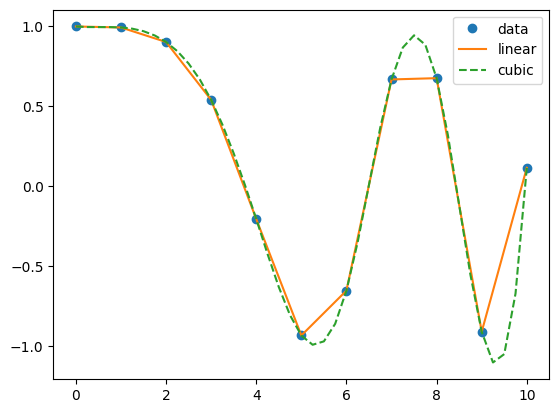

In [55]:
xnew = np.linspace(0, 10, num=41, endpoint=True)
print(xnew[:5])
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

In [64]:
##########################################################################

# returns the index where the value can be inserted (from left) without changing the order of elements.
print(bisect.bisect_left([1,2,3,4,5], 3))
print(bisect.bisect_left([1,2,4,5], 3))
print('#'*5)

# returns the index where the value can be inserted (from right) without changing the order of elements.
# when the target to locate is in the list, bisect_left, bisect_right return different result.
print(bisect.bisect_right([1,2,3,4,5], 3))
print(bisect.bisect_right([1,2,4,5], 3))

print('#'*5)
print(bisect.bisect_left([0,0,0,0], 0))
print(bisect.bisect_right([0,0,0,0], 0))

2
2
#####
3
2
#####
0
4


In [70]:
############################################################################################
# An OrderedDict is a dictionary that remembers the order of the keys that were inserted first. If a new entry 
#                              overwrites an existing entry, the original insertion position is left unchanged.
numbers = OrderedDict(one=1, five=5, two=2,)
print(numbers)

numbers["two"] = 22
print(numbers)

numbers["three"] = 3
numbers

# newly added item, is placed at the end of the underlying dictionary, so the order of the existing items remains 
#                                                                                                      unaffected.

OrderedDict([('one', 1), ('five', 5), ('two', 2)])
OrderedDict([('one', 1), ('five', 5), ('two', 22)])


OrderedDict([('one', 1), ('five', 5), ('two', 22), ('three', 3)])

In [87]:
d = {'b': 1, 'a': 2}
od = OrderedDict([('b', 1), ('a', 2)])

# they are equal with content and order
assert d == od
assert list(d.items()) == list(od.items())
assert repr(d) == repr(dict(od))
assert str(d) == str(od)
# difference between the string representation of the two object.

AssertionError: 

In [88]:
d_set = set(dir(d))
od_set = set(dir(od))
od_set.difference(d_set)

{'__dict__', 'move_to_end'}

In [91]:
################################################################################33
A = torch.randn(2, 3, 4, 5)
print(A.shape)

# label every dimension of the input operands with some subscript and define which subscripts are part of the 
#                                                                                                      output. 
torch.einsum('...ij->...ji', A).shape

torch.Size([2, 3, 4, 5])


torch.Size([2, 3, 5, 4])

In [104]:
# batch matrix multiplication.
As = torch.randint(0, 30, (3,2,5))
print(As, '\n')
Bs = torch.randint(0, 60, (3,5,4))
print(Bs, '\n')

# .einsum(...)  => Sums the product of the elements of the input operands along dimensions specified using a 
#                  notation based on the Einstein summation convention.
#                  Operands are separated by a comma (‘,’).


# output is computed by summing the product of the elements of the operands along the dimensions whose 
#         subscripts are not part of the output. 
#         output subscripts must appear at least once for some input operand and at most once for the output.
#         j is the summation subscript i.e., j dimension is contracted.
#         bik is the output script and (i and k the output subscripts).
#         bjk is the input script and (j and k the input subscripts). 

# 
print(torch.einsum('bij,bjk->bik', As, Bs)) # bij for 3D data.
torch.einsum('bij,bjk->bik', As, Bs).shape


tensor([[[ 0, 26,  6, 25, 16],
         [14, 23,  4, 28,  8]],

        [[ 3, 11,  5,  4,  7],
         [ 9, 10, 13, 25,  6]],

        [[ 4, 16, 15,  3, 22],
         [ 5, 27,  4, 21, 10]]]) 

tensor([[[31, 48,  3, 15],
         [38, 37, 26, 49],
         [27, 54, 27, 25],
         [49, 10, 48,  6],
         [ 1, 43, 46, 18]],

        [[30, 49, 30, 56],
         [59,  7,  7, 12],
         [ 2, 47,  5, 55],
         [43, 33,  5, 43],
         [52, 40, 59, 53]],

        [[19, 25, 34, 27],
         [55, 10, 41, 13],
         [27, 38, 19,  7],
         [41, 12, 35, 18],
         [33, 13, 27, 56]]]) 

tensor([[[2391, 2224, 2774, 1862],
         [2796, 2363, 2460, 1749]],

        [[1285,  871,  625, 1118],
         [2273, 2187,  884, 2732]],

        [[2210, 1152, 1776, 1707],
         [2879,  929, 2358, 1452]]])


torch.Size([3, 2, 4])

In [106]:
# torch.trace: sum of main-diagonal elements.
t = torch.randint(0, 16, (4,4))
print(t)

# output script is not present (i.e., no dimension in output) means output is a single element.
torch.einsum('ii', t) # or torch.einsum('ii->', t)
# 11+13+9+2 = 35

tensor([[11, 14,  7, 12],
        [10, 13, 12, 10],
        [ 8,  2,  9,  7],
        [ 7,  5,  8,  2]])


tensor(35)

In [107]:
# extract elements along the main-diagonal.
d = torch.randint(0, 16, (4,4))
print(d)
torch.einsum('ii->i', d)

tensor([[ 2,  1,  3,  7],
        [10,  3,  8, 13],
        [ 9,  1,  6, 11],
        [ 4, 14,  0, 10]])


tensor([ 2,  3,  6, 10])

In [114]:
# outer product.
p1 = torch.randint(0, 5, (5,))
print(p1)
p2 = torch.randint(0, 4, (4,))
print(p2)

# "each element of ith dimension in 1st operand" is multiplied with "jth dimension of 2nd operand".
torch.einsum('i,j->ij', p1, p2) # [[0*3 0*1 0*2 0*3] [3*3 3*1 3*2 3*3] ... ]

tensor([0, 3, 4, 3, 0])
tensor([3, 1, 2, 3])


tensor([[ 0,  0,  0,  0],
        [ 9,  3,  6,  9],
        [12,  4,  8, 12],
        [ 9,  3,  6,  9],
        [ 0,  0,  0,  0]])

In [122]:
# inner product.
p3 = torch.randint(0, 5, (5,))
print(p3)
# output script is not present (i.e., no dimension in output) means output is a single element.
torch.einsum("i,i->", p1, p3)

tensor([1, 2, 4, 0, 2])


tensor(22)

In [117]:
# element-wise product of two tensors.
e1 = torch.randint(0, 16, (4,4))
print(e1, '\n')
e2 = torch.randint(16, 32, (4,4))
print(e2, '\n')
torch.einsum('ij,ij->ij', e1, e2)

tensor([[ 2, 12, 10, 14],
        [ 0, 13, 15,  9],
        [ 3,  7,  2,  6],
        [12, 13, 10, 10]]) 

tensor([[19, 19, 31, 26],
        [31, 30, 25, 30],
        [26, 24, 29, 16],
        [27, 20, 26, 22]]) 



tensor([[ 38, 228, 310, 364],
        [  0, 390, 375, 270],
        [ 78, 168,  58,  96],
        [324, 260, 260, 220]])

In [118]:
# element-wise squaring.
torch.einsum('ij,ij->ij', e1, e1)

tensor([[  4, 144, 100, 196],
        [  0, 169, 225,  81],
        [  9,  49,   4,  36],
        [144, 169, 100, 100]])

In [119]:
# element-wise cube i.e., nth power.
torch.einsum('ij,ij,ij->ij', e1, e1, e1)

tensor([[   8, 1728, 1000, 2744],
        [   0, 2197, 3375,  729],
        [  27,  343,    8,  216],
        [1728, 2197, 1000, 1000]])

In [124]:
# sum along axis=0 i.e., output script contains only jth dimension so sum along this jth dimension.
torch.einsum("ij->j", e1)

tensor([17, 45, 37, 39])

In [125]:
As = torch.randint(0, 30, (3,2,5))
print(As, '\n')

# sum along axis=2 i.e., output script contains only axis 0 and 1 so sum along axis 2.
torch.einsum("bij -> bi", As)

# 24+10+27+9+24 = 94, 13+17+27+21+3 = 81

tensor([[[24, 10, 27,  9, 24],
         [13, 17, 27, 21,  3]],

        [[10, 19, 25, 13,  0],
         [21,  6,  3,  7, 26]],

        [[ 0, 16, 23, 11,  4],
         [ 9, 26,  0, 21, 11]]]) 



tensor([[94, 81],
        [67, 63],
        [54, 67]])

In [128]:
# some 4D multiplication
As = torch.randint(0, 10, (2,4,5,3))
print(As.shape, '\n')
Bs = torch.randint(10, 20, (2,5,5,3))
print(Bs.shape, '\n')
print(torch.einsum("bhic,bijc->bhij", As, Bs).shape) # torch.Size([2, 4, 5, 5])

# explained in next cells with small example.

torch.Size([2, 4, 5, 3]) 

torch.Size([2, 5, 5, 3]) 

torch.Size([2, 4, 5, 5])


In [129]:
As = torch.randint(0, 10, (1,1,2,1))
print(As.shape, '\n', As, '\n\n')
Bs = torch.randint(0, 10, (1,2,2,1))
print(Bs.shape, '\n', Bs, '\n\n')
result = torch.einsum("bhic,bijc->bhij", As, Bs)
print(result.shape)
result

torch.Size([1, 1, 2, 1]) 
 tensor([[[[1],
          [7]]]]) 


torch.Size([1, 2, 2, 1]) 
 tensor([[[[5],
          [0]],

         [[5],
          [5]]]]) 


torch.Size([1, 1, 2, 2])


tensor([[[[ 5,  0],
          [35, 35]]]])

In [132]:
As_ = As[:,:,:,None,:]    # torch.Size([1, 1, 2, 1, 1])
Bs_ = Bs[:,None,:,:,:]    # torch.Size([1, 1, 2, 2, 1])
print((As_*Bs_).shape)    # torch.Size([1, 1, 2, 2, 1])
(As_*Bs_).sum(dim=4)

torch.Size([1, 1, 2, 2, 1])


tensor([[[[ 5,  0],
          [35, 35]]]])